In [1]:
import pandas as pd
import random
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import numpy as np
from sklearn.metrics import f1_score
import os
import torch
%matplotlib inline


In [2]:
pd_ori=pd.read_csv('all.csv')

In [3]:
df_bert=pd_ori[['review','label']]

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
sss= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df_bert, pd_ori['label']):
    strat_train_set=df_bert.iloc[train_index]
    strat_test_set=df_bert.iloc[test_index]
strat_train_set['label'].value_counts()/len(strat_train_set)

0    0.867784
1    0.132216
Name: label, dtype: float64

In [5]:
strat_test_set

,review,label
5765,I have to agree with most of the reviews. We h...,1
147584,after failing to get into Lupa without a reser...,0
171188,Wow! They are a delight!!!\n,1
183180,the food is always great. the service is great...,1
507873,Burgers are equivalent to something I'd get at...,0
...,...,...
272533,Best Korean food in K-town. The side dishes ar...,1
148768,Very interesting Japanese hidden izatakaya bas...,0
59147,This could be my new favorite restaurant in Ph...,0
74005,A cute restaurant which didn't live up to expe...,0


In [6]:
strat_train_set['label'].value_counts()/len(strat_train_set)

0    0.867784
1    0.132216
Name: label, dtype: float64

In [7]:
cuda_available = torch.cuda.is_available()
cuda_available

True

In [12]:
model_args = ClassificationArgs(
    num_train_epochs=3,
    output_dir='final_project_output_classify_epoch_1/',
    save_steps=40000)
model = ClassificationModel('distilbert',
                            'distilbert-base-uncased',
                            args=model_args,
                            use_cuda=cuda_available)
model.train(strat_train_set)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [16]:
#load the previously saved model
model=ClassificationModel('distilbert',
                          'final_project_output_classify_epoch_1/', args=model_args, use_cuda=cuda_available)

In [18]:
result_classify, model_outputs_classify, wrong_predictions_classify = model.eval_model(strat_test_set, f1=f1_score)
result_classify['auroc']

0.7160622716670737

In [28]:
y_pred=model.predict(strat_test_set['review'].tolist())

In [31]:
from sklearn.datasets import load_breast_cancer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pylab as plt

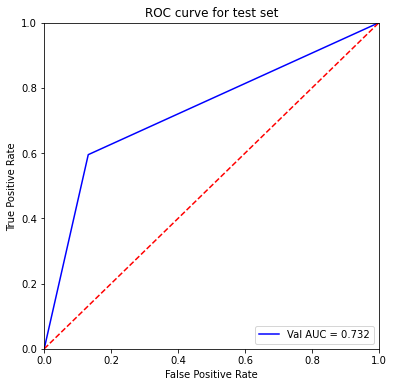

In [32]:
fpr, tpr, threshold = metrics.roc_curve(y_pred[0], strat_test_set['label'].tolist())
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('ROC curve for test set')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
